In [54]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo

In [55]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [56]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [57]:
# Get a set of pretrained model weights
weights = torchvision.models.DenseNet201_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [58]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [59]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=5)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a39af3e6f0>,
 ['high', 'low', 'medium'])

In [60]:
model = torchvision.models.densenet201(weights=weights).to(device)

In [61]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.parameters():
#     param.requires_grad = False

In [62]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1920, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [63]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [64]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=8,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 12%|█▎        | 1/8 [00:41<04:53, 41.93s/it]

Epoch: 1 | train_loss: 0.9775 | train_acc: 0.5000 | test_loss: 0.7028 | test_acc: 0.8000


 25%|██▌       | 2/8 [01:23<04:10, 41.81s/it]

Epoch: 2 | train_loss: 0.4983 | train_acc: 0.8667 | test_loss: 0.4656 | test_acc: 0.8400


 38%|███▊      | 3/8 [02:09<03:37, 43.49s/it]

Epoch: 3 | train_loss: 0.2755 | train_acc: 0.9556 | test_loss: 0.3165 | test_acc: 0.9600


 50%|█████     | 4/8 [02:51<02:52, 43.12s/it]

Epoch: 4 | train_loss: 0.2667 | train_acc: 0.9111 | test_loss: 0.2090 | test_acc: 0.9600


 62%|██████▎   | 5/8 [03:30<02:04, 41.59s/it]

Epoch: 5 | train_loss: 0.2641 | train_acc: 0.9111 | test_loss: 0.2492 | test_acc: 0.8800


 75%|███████▌  | 6/8 [04:09<01:21, 40.79s/it]

Epoch: 6 | train_loss: 0.1480 | train_acc: 0.9889 | test_loss: 0.2071 | test_acc: 0.9200


 88%|████████▊ | 7/8 [04:47<00:39, 39.76s/it]

Epoch: 7 | train_loss: 0.3227 | train_acc: 0.8889 | test_loss: 0.1889 | test_acc: 0.9600


100%|██████████| 8/8 [05:08<00:00, 38.52s/it]

Epoch: 8 | train_loss: 0.2153 | train_acc: 0.9000 | test_loss: 0.2363 | test_acc: 0.9200
[INFO] Total training time: 308.196 seconds


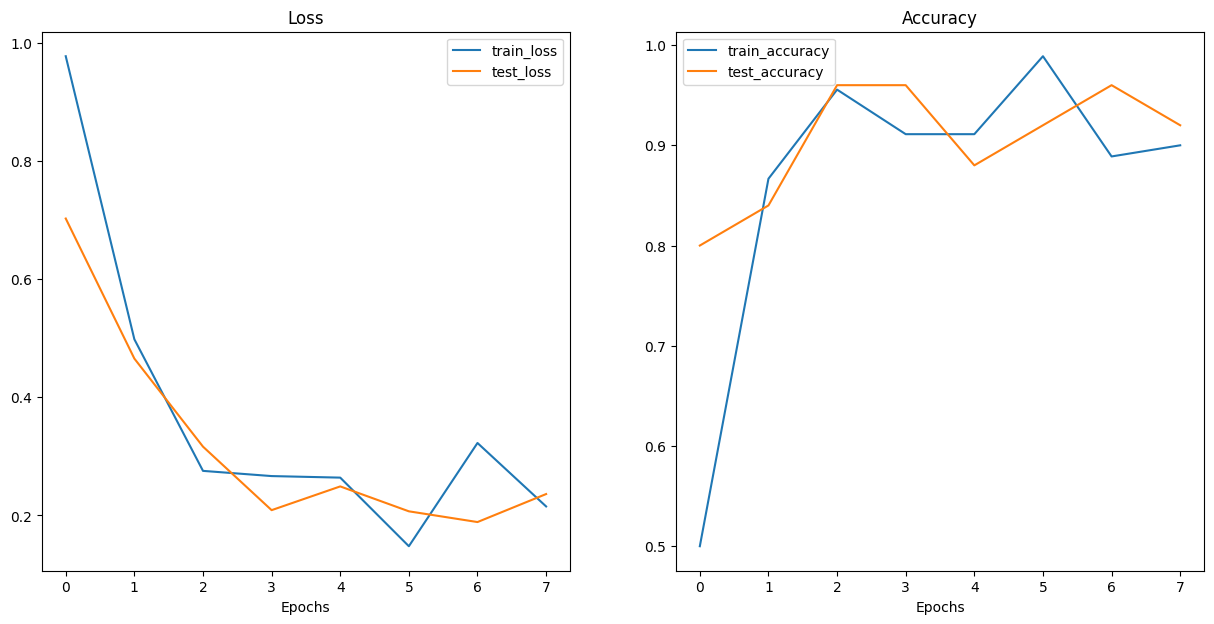

In [65]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)